<div align="center">
    <h1> Đồ án 02 Ứng dụng Dữ liệu lớn 19_21</h1>
    <h2> Nhóm 6 </h2>
</div>

19120615	Hùng Ngọc Phát  
19120621	Lê Minh Phục  
19120633	Nguyễn Anh Quốc  
19120689	Lại Khánh Toàn  

In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter

In [2]:
from nltk.tokenize import sent_tokenize

# Load dữ liệu

## Dữ liệu comment

In [3]:
df_fiveStars=pd.read_csv("data/raw/5_stars_subwaysurf.csv",sep=",")
df_oneStar=pd.read_csv("data/raw/1_star_subwaysurf.csv",sep=",")
df_cellphones = pd.read_csv("data/raw/CellphoneS_review.csv")
df_mobilecity = pd.read_csv("data/raw/Mobile_City_review.csv")
df_phonereview = pd.concat([df_cellphones, df_mobilecity])

/tmp/ipykernel_47408/3341891969.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fiveStars=pd.read_csv("data/raw/5_stars_subwaysurf.csv",sep=",")


## Dữ liệu 3000 từ phổ biến nhất trong tiếng Anh

In [4]:
eng_dict_df = pd.read_csv("dict/english-3k.txt", header=None)

In [5]:
eng_dict = eng_dict_df[0].to_list()

## Dữ liệu từ điển tiếng Việt

In [6]:
dict_df = pd.read_json("dict/words.txt", lines=True)

In [7]:
# Syllable tokenize từng entry trong từ điển
words_list = dict_df.text.apply(lambda x: re.split(r'[\s-]', x)).to_list()
len(words_list)

79197

Ta sẽ chuyển **từ điển** này thành **tự điển** (mỗi mục sẽ là một **tiếng** trong tiếng Việt)

In [8]:
# Flatten
words_list = [w.lower() for entry in words_list for w in entry]

In [9]:
words_list = set(words_list)
len(words_list)

10262

# Preprocess comment đơn giản

Đối với dữ liệu review điện thoại facebook: cắt các comment thành các câu.

In [10]:
df_phonereview["content"] = df_phonereview.content.map(sent_tokenize)

In [11]:
df_phonereview = df_phonereview.explode("content")

Các bước xử lý
- Bỏ các ký tự đặc biệt (emoji, biểu tượng, chữ tiếng Trung, ...)
- Bỏ HTML
- Bỏ URL
- Bỏ các số
- Chuẩn hoá unicode NFC

In [12]:
import re
import unicodedata


def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    sentence = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,_^%&*]", "", sentence)
    cleantext = re.sub(emoji, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    return " ".join(rem_num.strip().split())

Chỉ giữ lại các câu dài hơn 4 từ

In [13]:
def process_df(df):
    clean_text = df["content"].map(preprocess).map(lambda x: unicodedata.normalize("NFC", x))
    clean_text = clean_text.replace("", np.nan)
    
    df["cleanText"] = clean_text
    df = df.dropna(subset=["cleanText"])
    
    text_length = df["cleanText"].map(lambda x: len(x.split()))
    df = df[text_length > 4]
    return df

In [14]:
df_oneStar = process_df(df_oneStar)
df_fiveStars = process_df(df_fiveStars)
df_phonereview = process_df(df_phonereview)

In [15]:
df_oneStar = df_oneStar.sample(6000, random_state=0)
df_fiveStars = df_fiveStars.sample(6000, random_state=0)

# Tiếp tục preprocess kết hợp EDA

In [16]:
one_star_df = df_oneStar
five_star_df = df_fiveStars
phone_review_df = df_phonereview

## Tokenize theo âm tiết

In [17]:
one_star_df["tokens"] = one_star_df.cleanText.str.split()
five_star_df["tokens"] = five_star_df.cleanText.str.split()
phone_review_df["tokens"] = phone_review_df.cleanText.str.split()

## Liệt kê ra những từ trong comment mà không có trong tự điển

In [18]:
def list_exotic_words(sent):
    # Hàm trả về danh sách các từ không tồn tại trong tự điển tiếng Việt cho một câu
    exotic_words = []
    for word in sent:
        if word not in words_list:
            exotic_words.append(word)
    return set(exotic_words)

one_star_df["exotic_words"] = one_star_df.tokens.apply(list_exotic_words)
five_star_df["exotic_words"] = five_star_df.tokens.apply(list_exotic_words)
phone_review_df["exotic_words"] = phone_review_df.tokens.apply(list_exotic_words)

In [19]:
exotic_words = [w for sent in one_star_df["exotic_words"] for w in sent]
exotic_words += [w for sent in five_star_df["exotic_words"] for w in sent]

**Danh sách top 100 từ phổ biến nhất mà không có trong từ điển**

In [20]:
exotic_counter = Counter(exotic_words)
most_common_exotic = exotic_counter.most_common(100)
most_common_exotic

[('game', 3954),
 ('đc', 587),
 ('dc', 332),
 ('lag', 237),
 ('chs', 217),
 ('duoc', 189),
 ('hack', 180),
 ('thich', 178),
 ('lun', 141),
 ('khong', 127),
 ('cac', 126),
 ('mik', 100),
 ('luon', 99),
 ('facebook', 95),
 ('nhieu', 93),
 ('gem', 87),
 ('good', 83),
 ('nguoi', 81),
 ('wa', 79),
 ('subway', 76),
 ('vn', 72),
 ('this', 72),
 ('dau', 69),
 ('vl', 69),
 ('ae', 68),
 ('is', 68),
 ('hk', 61),
 ('that', 61),
 ('very', 60),
 ('like', 56),
 ('mat', 55),
 ('nhat', 54),
 ('vs', 54),
 ('and', 54),
 ('geam', 51),
 ('mk', 51),
 ('you', 51),
 ('play', 50),
 ('ng', 50),
 ('tuyet', 50),
 ('skin', 49),
 ('lol', 48),
 ('thik', 48),
 ('fb', 46),
 ('wifi', 45),
 ('cx', 45),
 ('dk', 43),
 ('het', 43),
 ('cap', 43),
 ('love', 43),
 ('biet', 43),
 ('surfers', 42),
 ('cuc', 42),
 ('đm', 42),
 ('rât', 42),
 ('update', 40),
 ('luc', 40),
 ('phien', 40),
 ('bn', 40),
 ('mot', 39),
 ('tien', 39),
 ('map', 38),
 ('dat', 36),
 ('free', 35),
 ('acc', 35),
 ('muon', 35),
 ('games', 34),
 ('bt', 33),
 ('

## Thay thế các từ teencode

Nhóm sử dụng 2 "từ điển" để thực hiện thay thế. Một từ điển được tải về từ trang [xltiengviet](https://xltiengviet.fandom.com/wiki/Danh_s%C3%A1ch_teencode_ph%E1%BB%95_bi%E1%BA%BFn_trong_ti%E1%BA%BFng_Vi%E1%BB%87t), một từ điển được nhóm trích từ 100 từ phổ biến nhất từ dataset như ở trên. Từ điển tải về từ web trên sẽ được ưu tiên hơn vì vốn từ nhiều hơn.

Các từ teencode tục tĩu (từ dataset trên) sẽ được nhóm gán lại thành nhãn `PROFANE`. Các từ tục tĩu không nằm trong danh sách ở trên sẽ được giữ nguyên (thường mang tính tiêu cực, có thể giúp mô hình dễ dàng nhận diện đó là câu tiêu cực).

Trong các chữ này, một số chữ sẽ được bổ sung vào tự điển, một số chữ sẽ được sửa lại theo nghĩa phổ biến nhất của nó. Ví dụ:
- đc: được
- chs: chơi
- mik: mình
- ...

"Luật" thay thế được nhóm viết ở file `replace_rule.csv`

Sau khi xong bước trên, các từ còn lại mà không có trong tự điển sẽ bị loại bỏ khỏi câu

In [21]:
teencode_df = pd.read_csv("dict/teen_code.tsv", sep="\t").set_index("key")
teencode_df

,value
key,
ctrai,con trai
khôg,không
bme,bố mẹ
cta,chúng ta
mih,mình
...,...
zô,dô
zú,vú
cmnd,chứng minh nhân dân


In [22]:
replace_rules_df = pd.read_csv("dict/replace_rules.csv").set_index("key")
replace_rules_df

,value
key,
đc,được
chs,chơi
dc,được
duoc,được
lun,luôn
...,...
dcm,PROFANE
j,gì
dkm,PROFANE


In [23]:
def replace_teencode(sent):
    final = []
    
    for word in sent:  
        if word in teencode_df.index:
            word_to_append = teencode_df.loc[word, "value"]
        if word in replace_rules_df.index:
            word_to_append = replace_rules_df.loc[word, "value"]
        else:
            word_to_append = word
        final.append(word_to_append)
    
    return final

In [24]:
replace_teencode("vcl gêm này chơi mãi mak dell xog đc dkm".split())

['PROFANE',
 'game',
 'này',
 'chơi',
 'mãi',
 'mà',
 'không',
 'xong',
 'được',
 'PROFANE']

In [25]:
one_star_df.tokens = one_star_df.tokens.apply(replace_teencode)
five_star_df.tokens = five_star_df.tokens.apply(replace_teencode)
phone_review_df.tokens = phone_review_df.tokens.apply(replace_teencode)

## Bỏ các từ không nằm trong tự điển tiếng Việt và 3000 từ phổ biến tiếng Anh

Hiện tại ta đã xử lý xong các từ teencode phổ biến. Những từ teencode còn lại sẽ bị loại bỏ hoàn toàn khỏi câu|

In [26]:
words_list.update(["game", "lag", "PROFANE", "good"])

In [27]:
def remove_teencode(sent):
    final = []
    for word in sent:
        if (word in eng_dict) or (word in words_list):
            final.append(word)
    
    return final

In [28]:
one_star_df.tokens = one_star_df.tokens.apply(remove_teencode)
five_star_df.tokens = five_star_df.tokens.apply(remove_teencode)
phone_review_df.tokens = phone_review_df.tokens.apply(remove_teencode)

## Tối hậu xử lý

Đây là bước xử lý cuối cùng. Các câu thoả 1 trong 2 điều kiện sau sẽ bị loại bỏ
- Có độ dài < 3
- Có > 50% các chữ không nằm trong tự điển tiếng Việt

Các token sẽ được nối lại thành 1 câu như ban đầu

In [29]:
def final_keep(sent):
    if len(sent) < 3:
        return False
    
    n_vi = 0
    for word in sent:
        if word in words_list:
            n_vi += 1
        
    if n_vi / len(sent) < 0.5:
        return False
    
    return True

In [30]:
one_star_df = one_star_df[one_star_df.tokens.apply(final_keep)]
five_star_df = five_star_df[five_star_df.tokens.apply(final_keep)]
phone_review_df = phone_review_df[phone_review_df.tokens.apply(final_keep)].copy()

In [31]:
one_star_df = one_star_df.tokens.apply(lambda x: " ".join(x)).to_frame()
five_star_df = five_star_df.tokens.apply(lambda x: " ".join(x)).to_frame()

phone_review_df["cleanText"] = phone_review_df.tokens.apply(lambda x: " ".join(x))

# Gán nhãn nhanh bằng thư viện underthesea

Dữ liệu từ google play rất hỗn loạn và nhiều nên nhóm sẽ tiến hành dán nhãn tự động trước và kiểm tra lại sau.

Với dữ liệu phone review, nhóm dán nhãn hoàn toàn thủ công.

In [32]:
import os.path
from underthesea import sentiment
from underthesea.model_fetcher import ModelFetcher
from joblib import load

In [33]:
# Để thư viện tự động download model về
sentiment("thử nghiệm")

Mặc định thư viện sẽ không trả về xác suất của các class. Nhóm đã đọc source code của thư viện và tìm ra cách load model thủ công lên để sử dụng trực tiếp sklearn pipeline đã train sẵn của thư viện.

In [34]:
model_path = ModelFetcher.get_model_path("SA_GENERAL_V131")
model_path = os.path.join(model_path, "pipeline.joblib")

In [35]:
clf = load(model_path)

In [36]:
def sentimental_predict(sentences):
    embed = clf[0].transform(sentences)
    y_hat = clf[1]._predict_proba_lr(embed)
    return y_hat

In [37]:
five_star_df[["neg_score", "neu_score", "pos_score"]] = sentimental_predict(five_star_df.tokens)
one_star_df[["neg_score", "neu_score", "pos_score"]] = sentimental_predict(one_star_df.tokens)

In [38]:
one_star_df.sample(5)

,tokens,neg_score,neu_score,pos_score
3343,tôi rất thích trò chơi này,0.228695,0.257136,0.514168
2359,tải video lúc được lúc không đang chơi mà tải ...,0.289147,0.417150,0.293704
9412,lúc vào game thì lâu ơi là lâu,0.404163,0.339140,0.256697
24,cập nhật xong không đăng nhập được nữa là sao,0.377559,0.368529,0.253912
6255,rất hay nhưng mà thấy mọi người cứ cho một sao...,0.340983,0.396335,0.262682


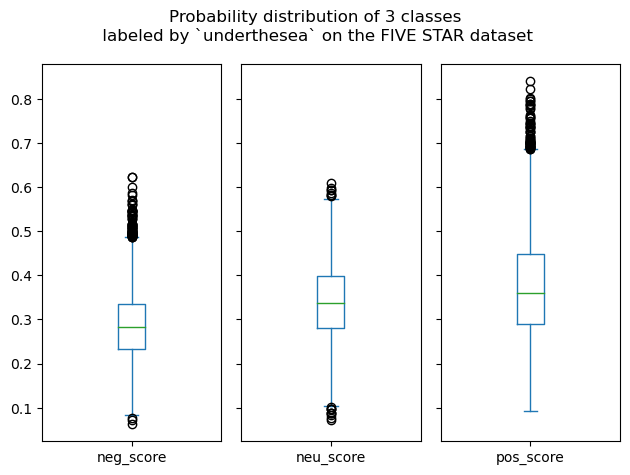

In [39]:
fig, ax = plt.subplots(ncols=3, sharey=True)
five_star_df.neg_score.plot(kind="box", ax=ax[0])
five_star_df.neu_score.plot(kind="box", ax=ax[1])
five_star_df.pos_score.plot(kind="box", ax=ax[2])
fig.suptitle("Probability distribution of 3 classes\n labeled by `underthesea` on the FIVE STAR dataset")
plt.tight_layout()

**Với tập các comment 5 sao**, ta thấy "confidence" của lớp negative không cao. Vậy ta sẽ giữ lại các comment 5* bằng cách lấy ra tập con của tập trên sao cho `pos_score > 0.2` và `neg_score < 0.3`. 

In [40]:
five_star_keep = five_star_df[(five_star_df.pos_score > 0.31)]
five_star_keep = five_star_keep.drop_duplicates(subset=["tokens"]).reset_index(drop=True)

In [41]:
five_star_keep

,tokens,neg_score,neu_score,pos_score
0,trò này là trò tôi thích nhất,0.222274,0.249790,0.527937
1,game rất hay tôi se uý ho tiếp,0.268160,0.303166,0.428675
2,chơi rất hay những tải vê,0.191148,0.306701,0.502151
3,tôi thấy phiên bản này rất tuyệt vời,0.187743,0.188068,0.624189
4,hay được tốt tôi thấy rất hay,0.172879,0.216511,0.610610
...,...,...,...,...
3765,hay rất hay nhưng có điều mình chơi nhiều nhưn...,0.256461,0.327219,0.416320
3766,tôi chơi tôi cảm thấy rất hay,0.320669,0.212075,0.467255
3767,rất hay luôn cho sao,0.290482,0.246731,0.462786
3768,trò chơi rất hay giải trí rất tuyệt cho sao,0.196078,0.226966,0.576955


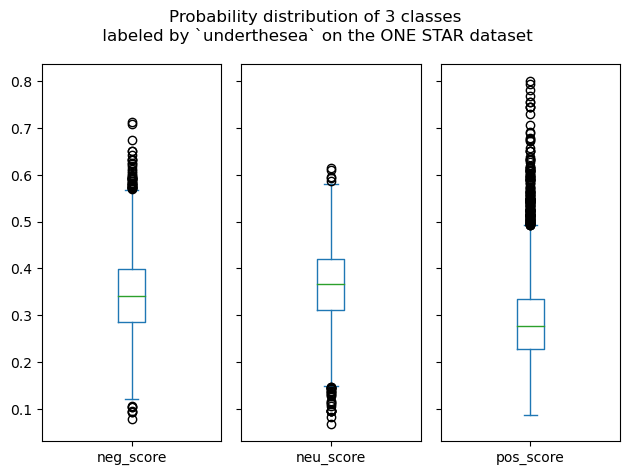

In [42]:
fig, ax = plt.subplots(ncols=3, sharey=True)
one_star_df.neg_score.plot(kind="box", ax=ax[0])
one_star_df.neu_score.plot(kind="box", ax=ax[1])
one_star_df.pos_score.plot(kind="box", ax=ax[2])
fig.suptitle("Probability distribution of 3 classes\n labeled by `underthesea` on the ONE STAR dataset")
plt.tight_layout()

**Tập `one_star` "nhiễu" hơn đáng kể so với tập `five_star`** khi confidence của lớp `negative` không vượt quá mức 0.6, trong khi khoảng giá trị của `pos_score` lại khá rộng. 

Nhóm sẽ chọn ra các comment có `pos_score < 0.5` và `neg_score > 0.34`

In [43]:
one_star_keep = one_star_df[(one_star_df.pos_score < 0.5) & (one_star_df.neg_score > 0.34)]
one_star_keep = one_star_keep.drop_duplicates(subset=["tokens"]).reset_index(drop=True)

In [44]:
one_star_keep

,tokens,neg_score,neu_score,pos_score
0,tải xong rồi mà cập nhật l được cc gì hết,0.350758,0.340971,0.308272
1,chò cúng hay cho sao,0.391703,0.381028,0.227269
2,vì ứng dụng này đã khiến tôi bị khóa máy nó đã...,0.406606,0.267101,0.326292
3,sỹ l ủa au,0.361680,0.327944,0.310376
4,game dễ quá quyết định cho sao,0.390490,0.321801,0.287709
...,...,...,...,...
2961,tai ve ma chay không được chan,0.421620,0.304670,0.273710
2962,rất hay đang dùng thì bị thoát ra vào lại gây ...,0.388950,0.262027,0.349022
2963,lúc vào game thì lâu ơi là lâu,0.404163,0.339140,0.256697
2964,sao nhung xoa không xao được,0.464308,0.392421,0.143271


In [45]:
five_star_keep.to_csv("data/cleaned/five_star_clean.csv", index=None)

In [46]:
one_star_keep.to_csv("data/cleaned/one_star_clean.csv", index=None)

In [47]:
phone_review_df = phone_review_df[["cleanText", "label"]]

In [48]:
phone_review_df.to_csv("data/cleaned/phone_review_clean.csv", index=None)